In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import pandas as pd
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.spatial.distance import mahalanobis
import hdbscan
from scipy.stats import genextreme
from sklearn.covariance import MinCovDet  
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from joblib import Parallel, delayed
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_score, recall_score, confusion_matrix




In [3]:
# Filter for individual customers
ddf = dd.read_parquet('transactions.parquet')
ddf_individual = ddf[ddf['CUSTOMER_TYPE'] == 'Cá nhân']

# Compute the filtered dataframe to bring it into memory as a Pandas DataFrame
df_individual = ddf_individual.compute()

# Select specific columns
df_individual = df_individual[['CUST_CUSTNO', 'total_deposits', 'total_withdrawals']]

# Display the filtered dataframe
df_individual



,CUST_CUSTNO,total_deposits,total_withdrawals
0,0000007773223f2870cd370943080c676696b5281dbe75...,120.0,-4100.0
1,00002bfa6df6d71eb18c1669be8d381641529f0dcdbb2a...,5400.0,-9600.0
2,0000c38422e04ccb772df72ed8ddac2b100b3bc88600be...,50.0,0.0
3,00010f06847bee388c69aaabcef8a3bc6221db4f9e03bf...,0.0,-5000.0
4,00013c38ac340d54e458cc923fbfed7171c5586877fd60...,0.0,-67453.4
...,...,...,...
195139,fffeae132cbb21f07d46942cde6fe6af1895e37de37fec...,0.0,-27.0
195140,fffedbd9aabeeb0fbd3267484e5afa3ddbe03834319602...,0.0,-389.0
195141,ffff174fed6d742e6eb7b30843430e86fd6281ef8d96b4...,367.0,-671.75
195142,ffff9730c2642fc5484a35fef7543417deced83c277fab...,1100.0,-500.0


In [4]:
# Log Transform the Data
df_individual['log_total_deposits'] = np.log1p(df_individual['total_deposits'])
df_individual['log_total_withdrawals'] = np.log1p(df_individual['total_withdrawals'].abs())


In [5]:
# Prepare the data for clustering
features = df_individual[['log_total_deposits', 'log_total_withdrawals']].values

In [6]:
# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [7]:
print(features_scaled.shape)


(194043, 2)


In [8]:
# Define a custom function to compute silhouette score
def hdbscan_silhouette_score(X, model):
    labels = model.fit_predict(X)
    # Calculate silhouette score only if there are more than one cluster
    if len(set(labels)) > 1:
        return silhouette_score(X, labels)
    else:
        return -1  # If only one cluster is formed, return a low score

# Set up hyperparameters for tuning
param_grid = {
    'min_samples': [5, 10, 20, 30],
    'min_cluster_size': [50, 100, 200],
    'cluster_selection_epsilon': [0.0, 0.1, 0.2],
}

# Use RandomizedSearchCV with custom scoring
random_search = RandomizedSearchCV(
    estimator=hdbscan.HDBSCAN(),
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
    scoring=lambda est, X: hdbscan_silhouette_score(X, est)  # Use the custom scoring function
)

# Fit the random search to your data
random_search.fit(features_scaled)

# Output the best parameters
print("Best hyperparameters found: ", random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters found:  {'min_samples': 20, 'min_cluster_size': 50, 'cluster_selection_epsilon': 0.2}


In [8]:
# Initialize HDBSCAN with the best hyperparameters
best_hdbscan = hdbscan.HDBSCAN(
    min_samples=20,
    min_cluster_size=50,
    cluster_selection_epsilon=0.2
)

# Fit the model
df_individual['cluster'] = best_hdbscan.fit_predict(features_scaled)

# Display clustering results
print(df_individual[['CUST_CUSTNO', 'cluster']].head())


                                         CUST_CUSTNO  cluster
0  0000007773223f2870cd370943080c676696b5281dbe75...        1
1  00002bfa6df6d71eb18c1669be8d381641529f0dcdbb2a...        1
2  0000c38422e04ccb772df72ed8ddac2b100b3bc88600be...        0
3  00010f06847bee388c69aaabcef8a3bc6221db4f9e03bf...        0
4  00013c38ac340d54e458cc923fbfed7171c5586877fd60...        0


In [10]:
# Initialize an empty list to store Euclidean distances
euclidean_distances = []

# For each data point, calculate the Euclidean distance to the cluster center
for idx, label in enumerate(df_individual['cluster']):
    if label != -1:  # Only calculate for points that belong to clusters
        # Get the center of the cluster (mean of all points in the cluster)
        cluster_center = features_scaled[df_individual['cluster'] == label].mean(axis=0)
        # Calculate Euclidean distance between the point and the cluster center
        dist = np.linalg.norm(features_scaled[idx] - cluster_center)
    else:
        # Assign NaN for noise points (label -1)
        dist = np.nan  
    euclidean_distances.append(dist)

# Add the computed distances as a new column to the dataframe
df_individual['euclidean_distance'] = euclidean_distances

# Display the dataframe with the new distance column
print(df_individual[['CUST_CUSTNO', 'cluster', 'euclidean_distance']].head())


                                         CUST_CUSTNO  cluster  \
0  0000007773223f2870cd370943080c676696b5281dbe75...        1   
1  00002bfa6df6d71eb18c1669be8d381641529f0dcdbb2a...        1   
2  0000c38422e04ccb772df72ed8ddac2b100b3bc88600be...        0   
3  00010f06847bee388c69aaabcef8a3bc6221db4f9e03bf...        0   
4  00013c38ac340d54e458cc923fbfed7171c5586877fd60...        0   

   euclidean_distance  
0            0.768825  
1            0.353909  
2            1.379433  
3            1.243773  
4            1.959749  


In [20]:
# Save the dataframe as a Parquet file
df_individual.to_parquet("distance_dbscan.parquet", engine='pyarrow', index=False)

print("File 'distance_dbscan.parquet' has been saved successfully.")

File 'distance_dbscan.parquet' has been saved successfully.


In [10]:
# Filter for individual customers
df_distance = dd.read_parquet('distance_dbscan.parquet')
# Compute the filtered dataframe to bring it into memory as a Pandas DataFrame
df_distance = df_distance.compute()

df_distance

,CUST_CUSTNO,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,cluster,euclidean_distance,is_anomaly
0,0000007773223f2870cd370943080c676696b5281dbe75...,120.0,-4100.0,4.795791,8.318986,1,0.768825,False
1,00002bfa6df6d71eb18c1669be8d381641529f0dcdbb2a...,5400.0,-9600.0,8.594339,9.169623,1,0.353909,False
2,0000c38422e04ccb772df72ed8ddac2b100b3bc88600be...,50.0,0.0,3.931826,0.0,0,1.379433,False
3,00010f06847bee388c69aaabcef8a3bc6221db4f9e03bf...,0.0,-5000.0,0.0,8.517393,0,1.243773,False
4,00013c38ac340d54e458cc923fbfed7171c5586877fd60...,0.0,-67453.4,0.0,11.119207,0,1.959749,False
...,...,...,...,...,...,...,...,...
194038,fffeae132cbb21f07d46942cde6fe6af1895e37de37fec...,0.0,-27.0,0.0,3.332205,0,0.575050,False
194039,fffedbd9aabeeb0fbd3267484e5afa3ddbe03834319602...,0.0,-389.0,0.0,5.966147,0,0.624665,False
194040,ffff174fed6d742e6eb7b30843430e86fd6281ef8d96b4...,367.0,-671.75,5.908083,6.511374,1,0.665709,False
194041,ffff9730c2642fc5484a35fef7543417deced83c277fab...,1100.0,-500.0,7.003974,6.216606,1,0.576051,False


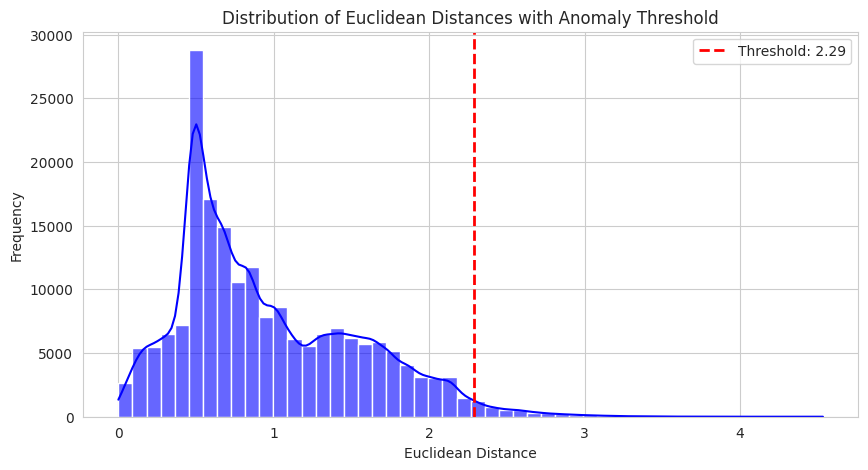

In [87]:
# Set plot style
sns.set_style("whitegrid")

# Define threshold (e.g., 99th percentile)
threshold = np.percentile(df_distance['euclidean_distance'].dropna(),98)

# Create figure
plt.figure(figsize=(10, 5))

# Plot histogram with KDE
sns.histplot(df_distance['euclidean_distance'].dropna(), bins=50, kde=True, color='blue', alpha=0.6)

# Add vertical threshold line
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f"Threshold: {threshold:.2f}")

# Labels and title
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Euclidean Distances with Anomaly Threshold")

# Add legend
plt.legend()

# Show plot
plt.show()


In [88]:
# Summary statistics for Euclidean distance
stats_summary = df_distance['euclidean_distance'].describe()
print(stats_summary)


count    194043.000000
mean          0.959619
std           0.578420
min           0.002156
25%           0.516156
50%           0.802664
75%           1.368062
max           4.533029
Name: euclidean_distance, dtype: float64


In [89]:
# Classify anomalies based on the threshold
df_distance['is_anomaly'] = df_distance['euclidean_distance'] > threshold

# Display anomalies (where 'is_anomaly' is True)
anomalies = df_distance[df_distance['is_anomaly'] == True]

print(f"Detected anomalies (total: {len(anomalies)}):")
print(anomalies[['CUST_CUSTNO', 'cluster', 'euclidean_distance', 'is_anomaly']].head())


Detected anomalies (total: 3881):
                                           CUST_CUSTNO  cluster  \
27   00099919531e7fea3b34dfdcd95f407350d6ebac8297a9...        0   
47   00154c1673dbc2b04836adbe6a2fbca4160d0eb86f3d46...        1   
50   001649736bcafeaf5a9c1c5c5262a7d4451df41b9c222c...        1   
99   00240c9e9e4ed96d37d551196a8b204b1c0e6ed2548ab8...        0   
116  002876f6357c8fb994a26b86c0609c2ac2511fb368da0b...        1   

     euclidean_distance  is_anomaly  
27             2.487260        True  
47             2.406129        True  
50             2.945184        True  
99             2.329118        True  
116            2.573273        True  


In [90]:
# Apply Rule 15 to detect anomalies in the dataset
rule_15_anomalies = df_distance[
    (
        (df_distance['total_deposits'].abs() >= 6000000) | 
        (df_distance['total_withdrawals'].abs() >= 6000000)
    ) & 
    (df_distance['total_withdrawals'].abs() >= 0.95 * df_distance['total_deposits'])
]

# Display Rule 15 anomalies
print(rule_15_anomalies[['CUST_CUSTNO', 'total_deposits', 'total_withdrawals','euclidean_distance','is_anomaly']].head())


                                            CUST_CUSTNO  total_deposits  \
50    001649736bcafeaf5a9c1c5c5262a7d4451df41b9c222c...      8593437.78   
1197  0191cf57de3d54f5112226efd558e976c801681f4736b5...     14023666.97   
1280  01a933d4323788d065e400b4b90eaa1e702f3fc5709574...      7889532.14   
1536  0202c9077426bdc83d1a46df8e062738c27632e1c35238...     13707567.12   
1614  0220168858cafaa2b38ef9fdc33c7ddabf9bf5716ab926...     21965418.69   

      total_withdrawals  euclidean_distance  is_anomaly  
50          -8508170.64            2.945184        True  
1197       -14022647.25            3.129402        True  
1280        -7820273.19            2.913683        True  
1536       -13603783.61            3.119245        True  
1614        -21960000.0            3.296119        True  


In [96]:
# Save to a Parquet file
rule_15_anomalies.to_parquet("rule_15_anomalies.parquet", index=False)

print(" anomalies saved to 'rule_15_anomalies.parquet'.")

 anomalies saved to 'rule_15_anomalies.parquet'.


In [91]:
# Identify the indices of Rule 15 anomalies
true_anomalies = rule_15_anomalies.index

# Step 2: Identify HDBSCAN anomalies (where 'is_anomaly' is True)
predicted_anomalies = df_distance[df_distance['is_anomaly'] == True].index

# Step 3: Calculate overlap between the true anomalies (Rule 15) and predicted anomalies (HDBSCAN)
overlap = set(true_anomalies) & set(predicted_anomalies)
true_positives = len(overlap)
false_positives = len(predicted_anomalies) - true_positives
false_negatives = len(true_anomalies) - true_positives

# Precision, Recall, F1 score calculations
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Display the results
print(f"True Anomalies (Rule 15): {len(true_anomalies)}")
print(f"Predicted Anomalies (HDBSCAN): {len(predicted_anomalies)}")
print(f"Overlap (Anomalies detected by both): {len(overlap)}")

# Print Precision, Recall, and F1 score
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

True Anomalies (Rule 15): 481
Predicted Anomalies (HDBSCAN): 3881
Overlap (Anomalies detected by both): 481
Precision: 0.1239
Recall: 1.0000
F1 Score: 0.2205


In [92]:
rule15_cif = pd.read_excel('CIF_HASH 14122024.xlsx')
rule15_cif = rule15_cif[['CUST']]
rule15_cif = rule15_cif.rename(columns={'CUST': 'CUST_CUSTNO'})
rule15_cif

,CUST_CUSTNO
0,4a7ac6a7d71c8dd43d07ea99ed57b947d4625ffb1ee7ba...
1,5ff908d766a8431c0480eaaa66f0c7f4f981ea36bb09db...
2,b585979be38eb995869128769142e7299db20874f0d8be...
3,55eeb636a10285eb1f8f8f5a6c2a8f210b2c5cc673546e...
4,039444b700a770ced03250af136ba9c2578a7136ef800d...
5,704f2775efdf525bc5319d057fc066417f464811e2889d...
6,fd9d7f98599e30315fbf5284f7a35ca8e52f9b10fcb43e...
7,21bc03333bc9f8a30ab9e8a05fbe675320dab245e282d3...
8,c7d19d1ad02b35b3a8c43f8381705ceac0a2c31cde3740...


In [74]:
ddf_filteredx = rule_15_anomalies.merge(rule15_cif, on='CUST_CUSTNO', how='right')
ddf_filteredx

,CUST_CUSTNO,total_deposits,total_withdrawals,log_total_deposits,log_total_withdrawals,cluster,euclidean_distance,is_anomaly
0,4a7ac6a7d71c8dd43d07ea99ed57b947d4625ffb1ee7ba...,42728096.58,-65899418.85,17.570367,18.00364,1,3.641288,True
1,5ff908d766a8431c0480eaaa66f0c7f4f981ea36bb09db...,19900681.84,-21928607.94,16.806265,16.903303,1,3.281261,True
2,b585979be38eb995869128769142e7299db20874f0d8be...,7273818.15,-21352635.78,15.799792,16.876686,1,3.132698,True
3,55eeb636a10285eb1f8f8f5a6c2a8f210b2c5cc673546e...,39516937.48,-58818914.14,17.49224,17.889974,1,3.604173,True
4,039444b700a770ced03250af136ba9c2578a7136ef800d...,8373577.74,-23412154.89,15.940592,16.968766,1,3.173495,True
5,704f2775efdf525bc5319d057fc066417f464811e2889d...,9248178.16,-27496356.23,16.039937,17.129564,1,3.224749,True
6,fd9d7f98599e30315fbf5284f7a35ca8e52f9b10fcb43e...,8204558.9,-24204558.94,15.920201,17.002052,1,3.178517,True
7,21bc03333bc9f8a30ab9e8a05fbe675320dab245e282d3...,7912330.19,-23524660.28,15.883933,16.97356,1,3.166892,True
8,c7d19d1ad02b35b3a8c43f8381705ceac0a2c31cde3740...,15326286.31,-45567572.46,16.54508,17.634707,1,3.412118,True


In [95]:
# Save to a Parquet file
ddf_filteredx.to_parquet("Bank results.parquet", index=False)

print(" anomalies saved to 'Bank results.parquet'.")

 anomalies saved to 'Bank results.parquet'.


In [93]:
# Sort the dataframe to get the top anomalies based on score
top_anomalies = df_distance[df_distance['is_anomaly']].sort_values(by='euclidean_distance', ascending=False)

# Display the top anomalies 
top_anomalies_display = top_anomalies.head(10)  # Show top 10 anomalies with highest score

# Display the top anomalies with the highestscores
print("High risky Anomalies with High Scores:")
print(top_anomalies_display[['CUST_CUSTNO', 'total_deposits', 'total_withdrawals', 'euclidean_distance']])



High risky Anomalies with High Scores:
                                              CUST_CUSTNO  total_deposits  \
16449   15b42f45f82bb2f3fae9a93030d59b4884a9301a643cbb...    615862697.16   
3807    05049a1941f462bcc2aa404a5476a932f6c8b058131d06...    148966211.52   
70721   5d46592a5feb8b5692cf5e62b9ff25366e6e54791e6fc0...     85661527.28   
132674  afa467fbd78003935a6a5a8e084186edf762df85d96d44...     85329202.11   
41629   36e455f05d73dc925ffe402781f2eb6dab866d639eb694...     80542821.95   
133323  b0858a70e277da8752eec249b279213ccf91954a8d4558...     92430258.08   
56306   4a49b23b2bb180324ae5ef5feaf288e07b42c6f81bd011...     78498265.33   
163650  d8168292b695c7bb5ce032a20dcb86b83ebe4bc59bac65...     61684602.79   
193149  fed6e67003861462eb13e4fdd8e4923a21e2bc84f0be07...     78002809.43   
32748                    2b357a1460c30a41fe106594e9191007      75906446.3   

        total_withdrawals  euclidean_distance  
16449       -610451234.37            4.533029  
3807        -1671

In [94]:
# Save to a Parquet file
top_anomalies_display.to_parquet("top_anomalies.parquet", index=False)

print("Top anomalies saved to 'top_anomalies.parquet'.")

Top anomalies saved to 'top_anomalies.parquet'.
